In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import warnings; warnings.filterwarnings('ignore')
import matplotlib.path as mpath

import sys; sys.path.append("..")
from dataset_manipulation import *
from palette import *
from plot import *

In [10]:
casealias = ['CTRL','IDEAL-ON', 'IDEAL-OFF', 'REAL-ON', 'REAL-OFF']
dpi = 300
relative = True
fig_folder = '../../figures/results/'

In [3]:
def load_dataset_dict(variable, cases=casealias, boreal_lat=45.):
    processed_path = '../../processed-data/postprocessing/' #/Users/adelezaini/Desktop/master-thesis/processed-data/output/IDEAL-ON_BVOC_20082012.nc
    date = '20082012'
    ds_dict = {}
    for case in cases:
        ds = xr.open_dataset(processed_path+case+'_'+variable+'_'+date+'.nc')
        ds = convert360_180(ds)
        #ds_dict[case] = ds.where(ds.LANDFRAC.mean('time')>0.)
        ds_dict[case]= ds.where(ds.lat>boreal_lat, drop=True)
    return ds_dict

# Albedo

In [4]:
radiative = load_dataset_dict('RADIATIVE')

def fix_names(ds):

    ds_ = ds.copy(deep=True)

    for var in ['SWDIR', 'LWDIR', 'DIR', 'SWCF', 'LWCF', 'NCFT', 'SW_rest', 'LW_rest']:
            
        
        if 'SWDIR' == var:
            ds_[var].attrs['long_name'] = "Shortwave aerosol direct radiative forcing"
        elif 'LWDIR' == var:
            ds_[var].attrs['long_name'] = "Longwave aerosol direct radiative forcing"
        elif 'DIR' == var:
            ds_[var].attrs['long_name'] = "Net aerosol direct radiative forcing"
        elif 'SWCF' == var:
            ds_[var].attrs['long_name'] = "Shortwave cloud radiative forcing"
        elif 'LWCF' == var:
            ds_[var].attrs['long_name'] = "Longwave cloud radiative forcing"
        elif 'NCFT' == var:
            ds_[var].attrs['long_name'] = "Net cloud radiative forcing"
        elif 'SW_rest' == var:
            ds_[var].attrs['long_name'] = "Shortwave surface albedo radiative forcing"
        elif 'LW_rest' == var:
            ds_[var].attrs['long_name'] = "Clear sky total column longwave flux"
    return ds_

for case in casealias:
    radiative[case] = fix_names(radiative[case])

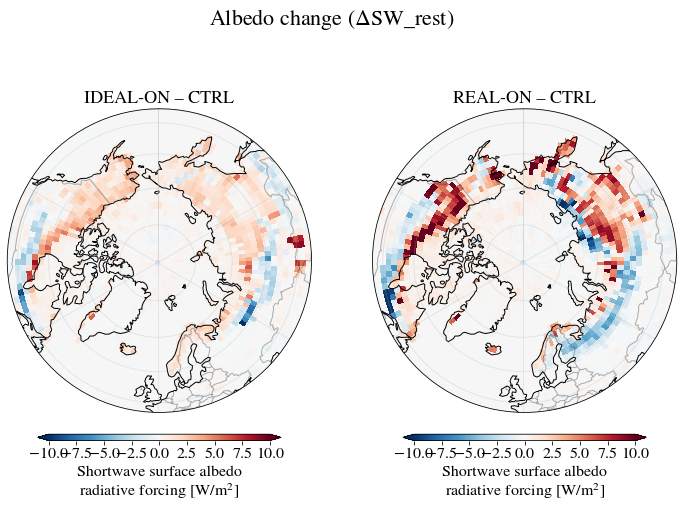

In [16]:
ds = radiative
var='SW_rest'
title=f'Albedo change ($\Delta$SW_rest)'
vmax=10

fig, axes = plt.subplots(1,2, figsize=[12,8], subplot_kw={'projection':ccrs.Orthographic(0, 90)})

plot_difference_map(ds, 'IDEAL-ON', 'CTRL', var, ax=axes.flat[0], vmax=vmax)
plot_difference_map(ds, 'REAL-ON', 'CTRL', var, ax=axes.flat[1], vmax = vmax)
plt.suptitle(title)
plt.savefig(fig_folder+var+'.pdf')
plt.show()

# PFT cover

In [30]:
land = load_dataset_dict('LAND', cases=['CTRL', 'IDEAL-ON', 'REAL-ON'])

In [37]:
def plot_difference_natpft(da_dict, case1, case2, variable,title, cmap='RdBu_r', **kwargs):
    
    fig, axes = plt.subplots(2,3, figsize=[18,12], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)
    diff = (da_dict[case1][variable].mean('time')-da_dict[case2][variable].mean('time'))
    
    natpft_names=['BoNET', 'BoNDT', 'BoBDT', 'Bo shrubs', 'artic C3 grass']
    for i, n in enumerate([2,3,8,11,12, 13]):
        if n==13: axes.flat[i].axis('off')
        else: boreal_map(diff.sel(natpft=n), ax = axes.flat[i], title=natpft_names[i], cmap=cmap,
                           extent_lat =45., vmax=50, **kwargs)
    plt.suptitle(title+': '+case1+' – '+case2)
    plt.show()  

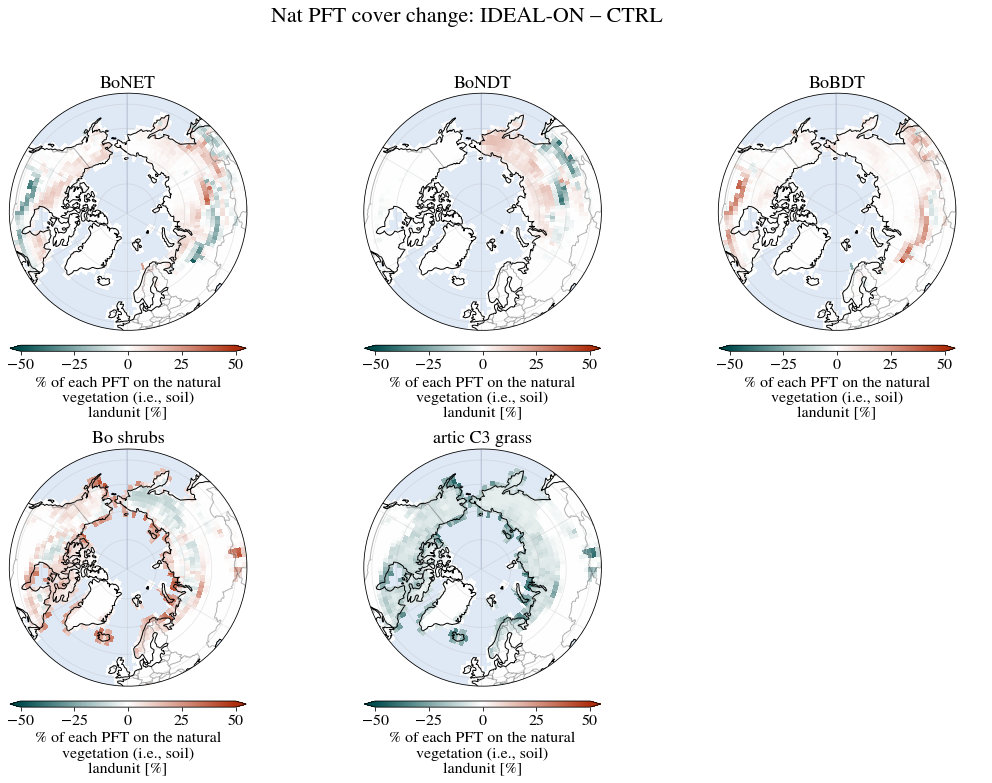

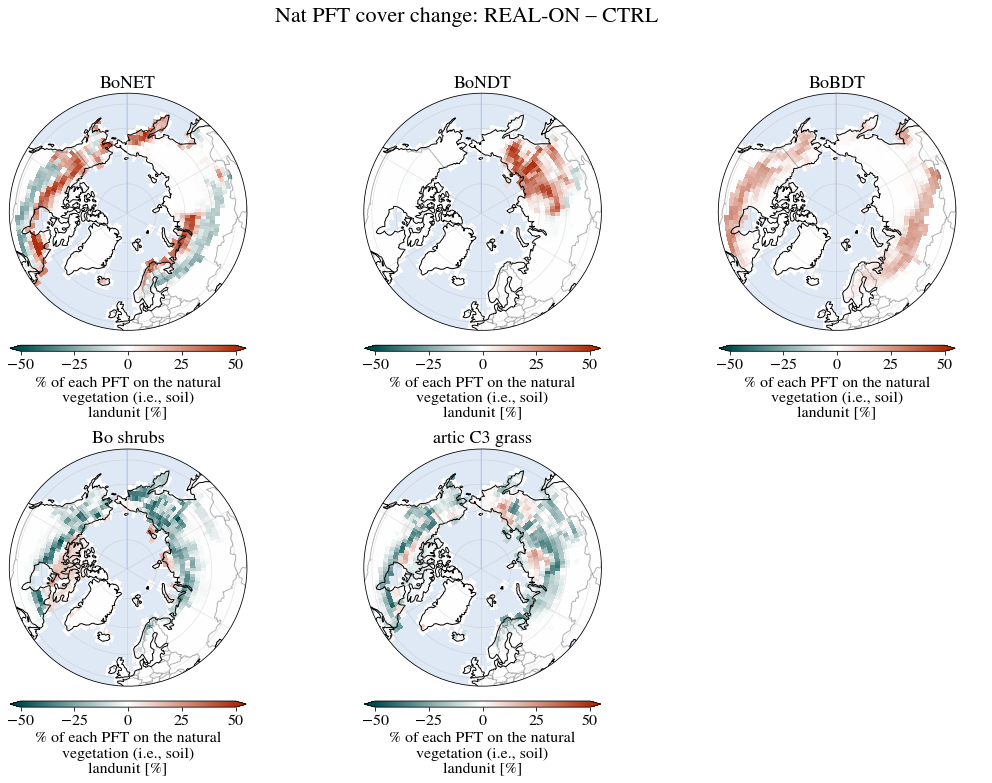

In [38]:
cmap=diverging_colormap('#014d4e', '#af2f0d')

plot_difference_natpft(land, 'IDEAL-ON', 'CTRL', 'PCT_NAT_PFT', 'Nat PFT cover change', cmap=cmap)
plot_difference_natpft(land, 'REAL-ON', 'CTRL', 'PCT_NAT_PFT', 'Nat PFT cover change', cmap=cmap)

# Evapotranspiration

In [18]:
et = load_dataset_dict('ET')

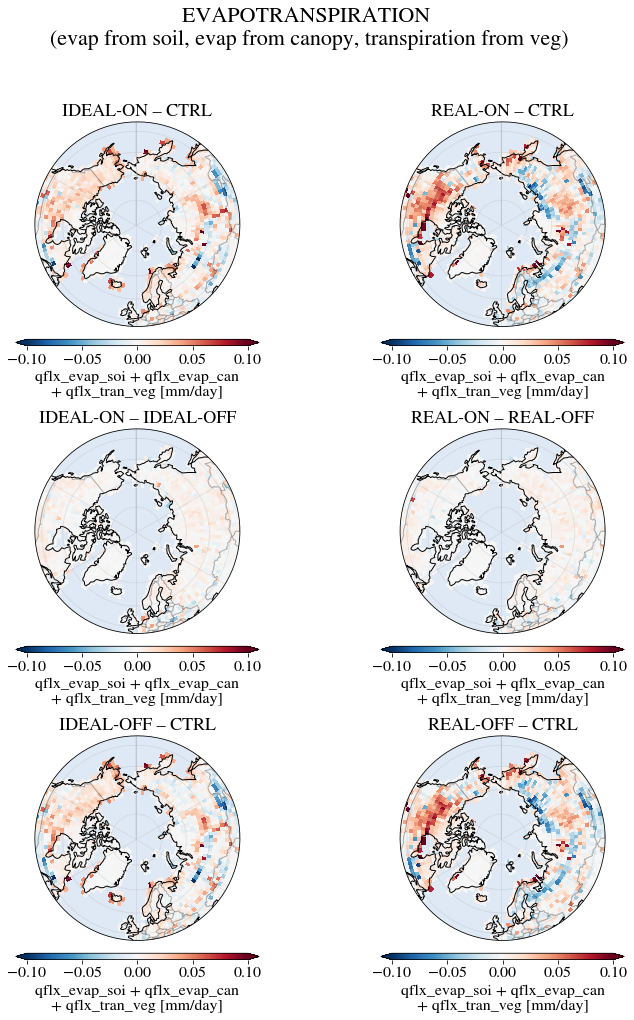

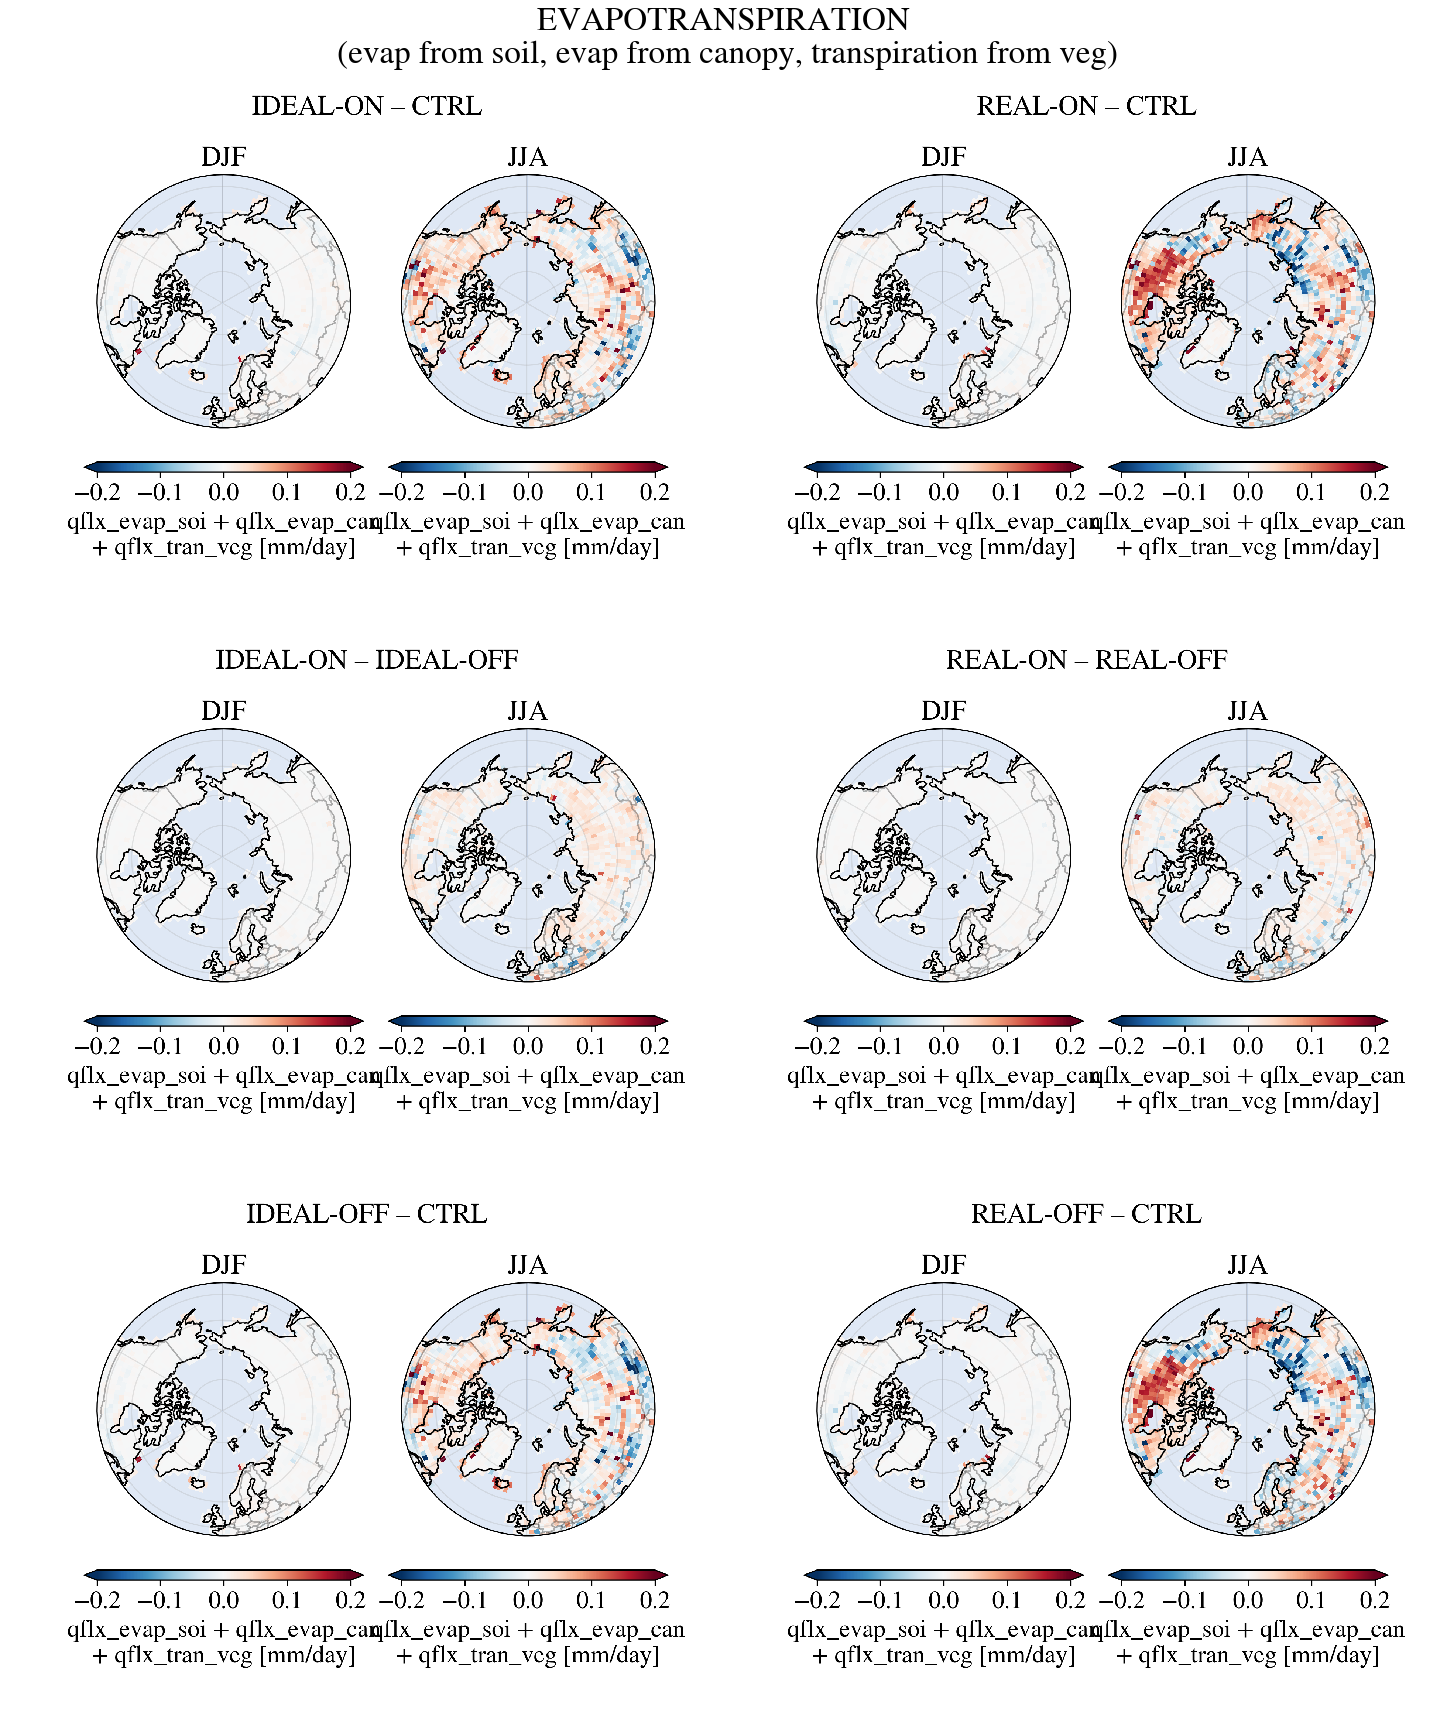

In [29]:
ds=et
variable='QFLX_EVAP_TOT'
title = 'EVAPOTRANSPIRATION \n(evap from soil, evap from canopy, transpiration from veg)'
relative=False
spatial_averages(ds, variable, title, vmax=0.1 if not relative else 15, relative = relative, cbar_kwargs=dict(ticks = [-0.1, -0.005,0, 0.005, 0.1]))
spatial_averages_winter_summer(ds, variable, title, dpi=dpi, vmax=0.2 if not relative else 25, relative = relative)#, cbar_kwargs = dict(ticks=[-1000, -500, 0, 500, 1000]))

NameError: name 'single_pft_map' is not defined

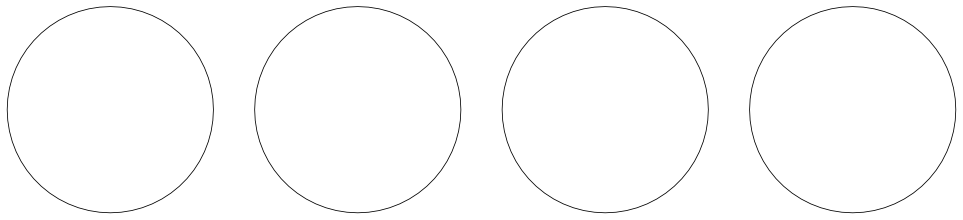

In [20]:
def plot_difference(da_dict, case1, case2, variable, ax = None, lev=False, **kwargs):
    
    diff = (da_dict[case1][variable].mean('time')-da_dict[case2][variable].mean('time'))#/da_dict[case2][variable].groupby('time.year').sum('time').mean('year')
    if lev: diff=diff.sum('lev').where(da_dict[case1].LANDFRAC.mean('time')>0.)
    single_pft_map(diff, ax = ax, title=case1+' – '+case2, cmap='RdBu_r', extent_lat =45.,**kwargs)
        
def plot_difference_by_season(da_dict, case1, case2, variable, title, lev=False,**kwargs):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    
    diff = (da_dict[case1][variable].groupby('time.season').mean('time')-da_dict[case2][variable].groupby('time.season').mean('time'))
    if lev: diff=diff.sum('lev').where(da_dict[case1].LANDFRAC.mean('time')>0.)
        
    fig, axes = plt.subplots(1,4, figsize=[17,5], subplot_kw={'projection':ccrs.Orthographic(0, 90)})#,dpi=100)
    
    for i, season in enumerate(seasons):
        single_pft_map(diff.sel(season=season), ax = axes.flat[i], title=season, cmap='RdBu_r', extent_lat =45.,**kwargs)
    plt.suptitle(title+': '+case1+' – '+case2, size=15)
    plt.show()
    
plot_difference_by_season(ds, 'IDEAL-ON', 'CTRL', var, title, vmax=50)
plot_difference_by_season(ds, 'REAL-ON', 'CTRL', var, title, vmax=50)

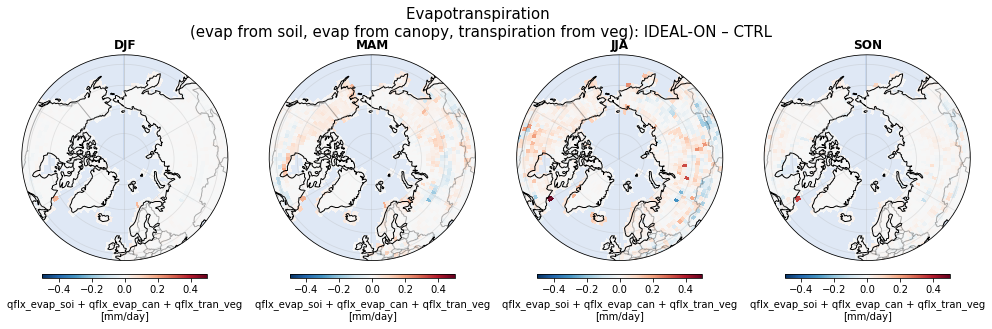

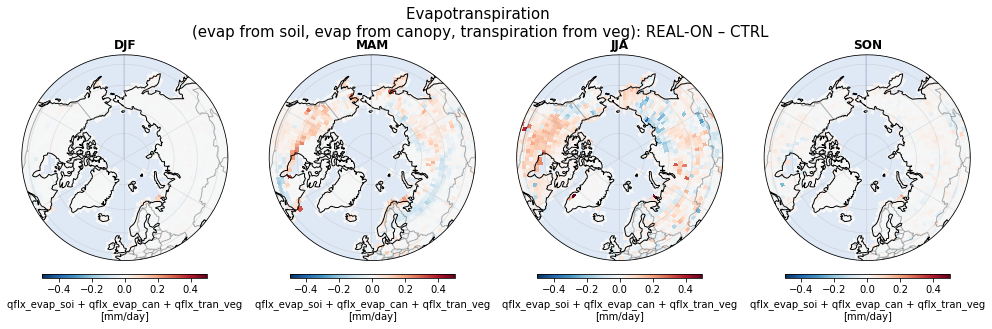

In [62]:
plot_difference_by_season(ds, 'IDEAL-ON', 'CTRL', var, title, vmax=0.5)
plot_difference_by_season(ds, 'REAL-ON', 'CTRL', var, title, vmax=0.5)